# Lectura de archivos

In [38]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [40]:
#id = '1FAjcexe-71nGuYIzvnQ46IdXVcqM9cx4'
#downloaded = drive.CreateFile({'id': id})
#downloaded.GetContentFile('test_values_complete_features.csv')

#test_values1 = pd.read_csv('test_values_complete_features.csv', encoding='latin-1', index_col='building_id')

#test_values1[test_values1.select_dtypes('O').columns] = test_values1[test_values1.select_dtypes('O').columns].astype('category')

id = '1Ovh3Zk12lL4Ya9vFHUCgu_nJ8yJIaSHd'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_values_selected_features_remix.csv')

test_values1 = pd.read_csv('test_values_selected_features_remix.csv', encoding='latin-1', index_col='building_id')

test_values1[test_values1.select_dtypes('O').columns] = test_values1[test_values1.select_dtypes('O').columns].astype('category')

In [41]:
#id = '1qs2mEnkqiAqebJE2SvqkrfoV66Edguwr'
#downloaded = drive.CreateFile({'id': id})
#downloaded.GetContentFile('train_values_complete_features.csv')

#train_values1 = pd.read_csv('train_values_complete_features.csv', encoding='latin-1', index_col='building_id')

#train_values1[train_values1.select_dtypes('O').columns] = train_values1[train_values1.select_dtypes('O').columns].astype('category')

id = '1PU2M7GRt5JpNgxybGciMKMoot42UCzDc'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values_selected_features_remix.csv')

train_values1 = pd.read_csv('train_values_selected_features_remix.csv', encoding='latin-1', index_col='building_id')

train_values1[train_values1.select_dtypes('O').columns] = train_values1[train_values1.select_dtypes('O').columns].astype('category')

In [42]:
id='1RUtolRcQlR3RGULttM4ZoQaK_Ouow4gc'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_labels.csv')
train_labels = pd.read_csv('train_labels.csv', encoding='latin-1', dtype={'building_id': 'int64', 'damage_grade': 'int64'}, index_col='building_id')

In [43]:
id='1br3fMwXX_J0XmiXvOm_wfKWvHSj45T3y'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_values.csv')
train_values2 = pd.read_csv('train_values.csv', encoding='latin-1', index_col='building_id')

train_values2[train_values2.select_dtypes('O').columns] = train_values2[train_values2.select_dtypes('O').columns].astype('category')

In [ ]:
id = '1kt2VFhgpfRS72wtBOBy1KDat9LanfMZU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_values.csv')
test_values2 = pd.read_csv('test_values.csv', encoding='latin-1', index_col='building_id')

test_values2[test_values2.select_dtypes('O').columns] = test_values2[test_values2.select_dtypes('O').columns].astype('category')

In [ ]:
train_values_complete = train_values1.copy()
test_values_complete = test_values1.copy()
train_values_incomplete = train_values2.copy()
test_values_incomplete = test_values2.copy()

In [44]:
#train_values = train_values_incomplete.copy()
#test_values = test_values_incomplete.copy()

train_values = train_values2.copy()
test_values = test_values2.copy()

In [45]:
train_values

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,n,r,n,f,j,s,q,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
669485,17,715,2060,2,0,6,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
602512,17,51,8163,3,55,6,7,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [46]:
test_values

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300051,17,596,11307,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
99355,6,141,11987,2,25,13,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
890251,22,19,10044,2,5,4,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
745817,26,39,633,1,0,19,3,t,r,x,v,j,t,d,0,0,0,0,0,1,0,0,0,0,0,v,2,1,0,0,1,0,0,0,0,0,0,0
421793,17,289,7970,3,15,8,7,t,r,q,f,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,4,605,3623,3,70,20,6,t,r,q,f,q,t,d,0,1,0,0,0,0,1,0,0,0,0,w,1,1,1,0,0,0,0,0,0,0,0,0
663567,10,1407,11907,3,25,6,7,n,r,n,f,q,s,d,1,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1049160,22,1136,7712,1,50,3,3,t,r,n,f,j,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
test_values['ground_floor_type'].dtype

CategoricalDtype(categories=['f', 'm', 'v', 'x', 'z'], ordered=False)

In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [49]:
def get_obj(train, p = False):
    obj_types = []
    for column in train.columns:
        if column in train.select_dtypes('category').columns: 
            if p: print(column)
            obj_types.append(column)
    return obj_types
    
obj_types = get_obj(train_values, True)

land_surface_condition
foundation_type
roof_type
ground_floor_type
other_floor_type
position
plan_configuration
legal_ownership_status


In [50]:
train_values['land_surface_condition'].dtype

CategoricalDtype(categories=['n', 'o', 't'], ordered=False)

In [51]:
def transform_to_int(train, obj_types):
    #Assign dictionaries with current values and replacements for each column
    d_lsc = {'n':0, 'o':1, 't':2}
    d_ft = {'h':0, 'i':1, 'r':2, 'u':3, 'w':4}
    d_rt = {'n':0, 'q':1, 'x':2}
    d_gft = {'f':0, 'm':1, 'v':2, 'x':3, 'z':4}
    d_oft = {'j':0, 'q':1, 's':2, 'x':3}
    d_pos = {'j':0, 'o':1, 's':2, 't':3}
    d_pc = {'a':0, 'c':1, 'd':2, 'f':3, 'm':4, 'n':5, 'o':6, 'q':7, 's':8, 'u':9}
    d_los = {'a':0, 'r':1, 'v':2, 'w':3}
    #d_ra = {'actual':0, 'historic':1, 'new':2, 'old':3, 'regular':4, 'regular_old':5}
    #Each positional index in replacements corresponds to the column in obj_types
    replacements = [d_lsc, d_ft, d_rt, d_gft, d_oft, d_pos, d_pc, d_los]

    try:
      #Replace using lambda Series.map(lambda)
      for i,col in enumerate(obj_types):
         train[col] = train[col].map(lambda a: replacements[i][a]).astype('int64')
    except:
      print(col)

transform_to_int(train_values, obj_types)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(train_values, train_labels)

rcf = RandomForestClassifier()
model = rcf.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [53]:
y_pred = model.predict(x_test)
f1_score(y_test, y_pred,average='micro')

0.7184080060167918

In [54]:
importance = pd.DataFrame({"Feature":list(train_values), "Importance": rcf.feature_importances_}) # build a dataframe with features and their importance
importance = importance.sort_values(by="Importance", ascending=False) #sort by importance
importance

,Feature,Importance
2,geo_level_3_id,0.154421
0,geo_level_1_id,0.139116
1,geo_level_2_id,0.135274
4,age,0.120996
5,area_percentage,0.111575
6,height_percentage,0.055839
26,count_families,0.024889
8,foundation_type,0.024019
9,roof_type,0.023916
12,position,0.022047


Elimino outliers de los parámetros más importantes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

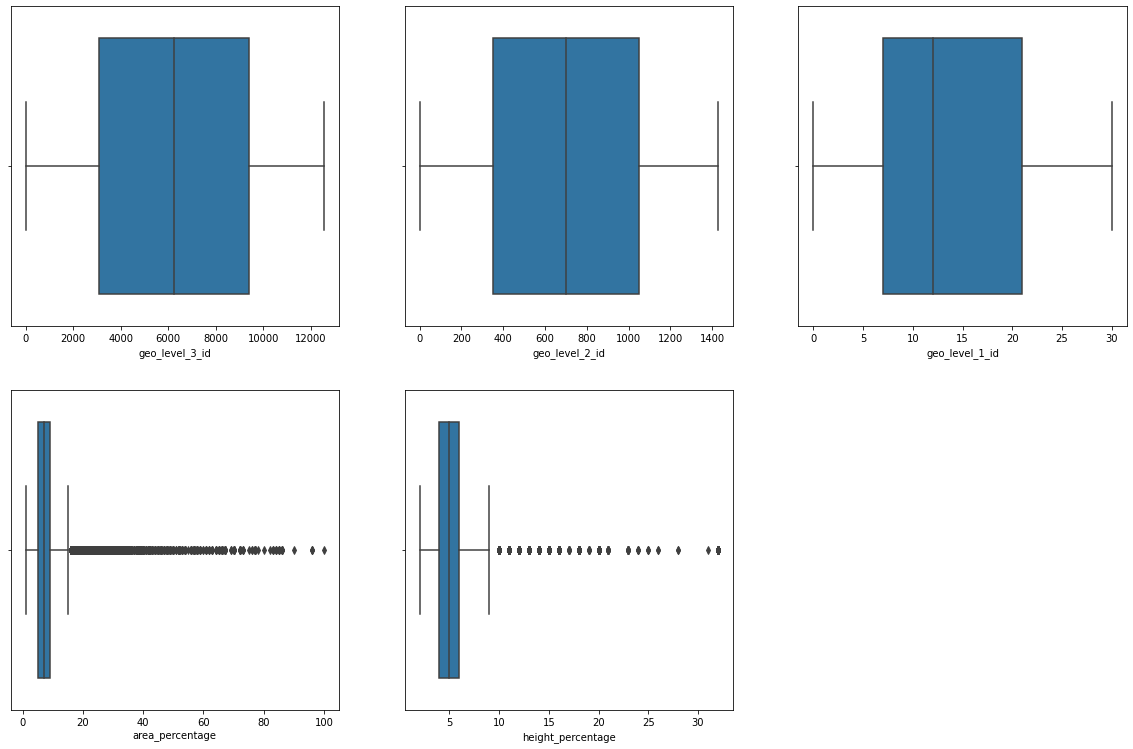

In [55]:
boxplot_cols=["geo_level_3_id","geo_level_2_id","geo_level_1_id", "area_percentage", "height_percentage"]
q=1
plt.figure(figsize=(20,20))
for j in boxplot_cols:
    plt.subplot(3,3,q)
    ax=sns.boxplot(train_values[j].dropna())
    plt.xlabel(j)
    q+=1
plt.show()

Se aprecia que para los de `geo_level_id` no hay outliers, pero para los otros 3 si.

In [56]:
import scipy

def remove_outliers(df, col_cutoff = 0.01, z_score = 3.5): #define a function to get rid of all outliers of the most important columns
    important_cols = importance[importance.Importance>col_cutoff]['Feature'].tolist() #get all columns with importance > 0.01.  
    df_new = df.copy() #init the new df
    for col in important_cols: df_new = df_new[np.abs(scipy.stats.zscore(df_new[col]))<z_score] #removing all rows where a z-score is >3
    return df_new

In [57]:
df = pd.concat([train_values, train_labels], axis = 1)

In [58]:
df_new = remove_outliers(df)

In [59]:
y = df_new.pop('damage_grade')
x = df_new

In [60]:
y.value_counts()

2    142749
3     84408
1     23098
Name: damage_grade, dtype: int64

Se removieron un montón de valores `damage_grade` = 1 porque eran outliers, lo que no es muy bueno.

Acá una justificación del valor elegido para el z_score:

Given the size of our dataset, ~ 260,000 samples, considering all variables with z scores > 3, as outliers, corresponding to 0.27% percentile, might be removing some useful data.

A z score of 3.5, corresponding with the 0.0465% could also be good enough to remove outliers, while preserving more samples. This way, the original distrbituion between damage grades may be better preserved too.

In [61]:
def get_original():
    df = train_values_incomplete.copy()
    #df.drop('building_id', axis =1, inplace=True)
    obj_types = get_obj(df)
    transform_to_int(df, obj_types)
    df['damage_grade'] = train_labels.damage_grade

    return df
    
df = get_original()

In [62]:
#función para volver a dividir df en train_values y train_labels
def get_xy(df):
    y = df.pop('damage_grade')
    x= df
    return x, y

x,y = get_xy(df) 

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [ ]:
!pip uninstall lightgbm

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/lightgbm-2.2.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/lightgbm/*
Proceed (y/n)? y
  Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5 MB 9.4 MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [72]:
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, hstack
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [ ]:
def test_model(model, removing = False, col_cutoff = 0.01, z_score = 3.5):
    df_train = pd.concat([x_train, y_train], axis = 1) #combine them together, so outliers are simultaneously removed from both
    if removing: df_train = remove_outliers(df_train, col_cutoff, z_score) 
    x, y = get_xy(df_train)
    model.fit(x, y)

    y_pred = model.predict(x_test)
    print(f1_score(y_test, y_pred, average='micro'))

In [ ]:
test_model(lgb.LGBMClassifier())
#test_model(lgb.LGBMClassifier(), True)

0.7112927362725913


In [ ]:
params = {'bagging_fraction': 0.9942503905640735,
 'bagging_freq': 5,
 'feature_fraction': 0.691531917374889,
 'lambda_l1': 3.4812288938993575e-06,
 'lambda_l2': 5.766315598279498e-05,
 'learning_rate': 0.099,
 'max_bin': 220,
 'max_depth': 9,
 'min_child_samples': 78,
 'min_child_weight': 16,
 'min_split_gain': 0.096,
 'n_estimators': 120,
 'num_iterations': 300,
 'num_leaves': 238}

In [ ]:
lg_classifier = lgb.LGBMClassifier(**params)
test_model(lg_classifier, True)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.7376155941828786


In [ ]:
xgbc = xgb.XGBClassifier( min_child_weight= 5, learning_rate= 0.1, gamma= 0.05, subsample= 0.8,colsample_bytree= 0.3, colsample_bynode= 0.8,
 colsample_bylevel= 0.8, max_depth = 20, n_estimators = 150)

In [ ]:
lg_classifier2 = lgb.LGBMClassifier(min_child_weight= 5, learning_rate= 0.1, gamma= 0.05, subsample= 0.8,colsample_bytree= 0.3, colsample_bynode= 0.8,
 colsample_bylevel= 0.8, max_depth = 20, n_estimators = 150)
test_model(lg_classifier)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.7408004297609455


In [ ]:
def submit_model(model, file_name):
    test = test_values_incomplete.copy()
    transform_to_int(test, get_obj(test))
    submission_predictions = model.predict(test)
    submission = pd.DataFrame()
    submission["building_id"] = test_values_incomplete.reset_index()['building_id']
    submission["damage_grade"] = submission_predictions
    submission.to_csv(file_name, index=False)

In [ ]:
submit_model(lg_classifier2, 'submission_lightgbm2.csv')

In [ ]:
pred_train_check = run_lightgmb(x_train, x_test, y_train, y_test, params)

In [73]:
def run_lightgmb(x_train, x_test, y_train, y_test, params={}):
  lgb_classifier = lgb.LGBMClassifier(**params)
  lgb_classifier.fit(x_train, y_train.values.ravel())

  pred = lgb_classifier.predict(x_test)
  score = f1_score(y_test, pred, average='micro')
  score = accuracy_score(y_test, pred)

  cm = confusion_matrix(y_test, pred)
  report = classification_report(y_test, pred)

  print("f1_micro: ", score, "\n\n")
  print(cm, "\n\n")
  print(report, "\n\n")

  #return pred
  return lgb_classifier

## Aplico random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
params = {'bagging_fraction': 0.9942503905640735,
 'bagging_freq': 5,
 'feature_fraction': 0.691531917374889,
 'lambda_l1': 3.4812288938993575e-06,
 'lambda_l2': 5.766315598279498e-05,
 'learning_rate': 0.099,
 'max_bin': 220,
 'max_depth': 9,
 'min_child_samples': 78,
 'min_child_weight': 16,
 'min_split_gain': 0.096,
 'n_estimators': 120,
 'num_iterations': 300,
 'num_leaves': 238}

In [ ]:
params_2 = [#{'learning_rate':[0.01,0.1, 0.2, 0.3,0.4]},
          #{'n_estimators':[500,600,700,800,900]},
          #{'num_leaves': [25]},
          #{'feature_fraction': [0.2, 0.3, 0.5, 0.6, 1]},   
          #{'bagging_fraction': [0.8, 1, 1.2]},
          #{'max_depth': [5, 10, 11,12,13,14,15,16,17,18]},
          {'lambda_l1':[1.7,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5]},
          {'lambda_l2': [2, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 4]},
          #{'min_split_gain': [0.01, 0.1, 1]},
          #{'min_child_weight': [1e-05, 0.01]}
          ]

In [ ]:
params_3 = {
    'learning_rate':(0.21,0.22,0.23,0.24, 0.245,0.25,0.26,0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.4,0.5,0.6,0.7, 1, 2),
    'n_estimators':(800,815,830,845,850,875,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000),
    'num_leaves': (18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33),
    'max_depth': (7, 8, 9, 10, 11,12,13,14,15,16,17,18, 19, 20, 21),
    'feature_fraction':(0.4, 0.45, 0.49,0.5,0.51, 0.52, 0.53, 0.54, 0.55, 0.56,0.57, 0.58,0.59, 0.6, 0.7, 0.8),
    'bagging_fraction': (0.7,0.72,0.74,0.76,0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.86, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4),
    'lambda_l1': (1.4,1.5,1.6,1.7,1.76, 1.78,1.8, 1.82, 1.84,1.85, 1.86, 1.87, 1.88, 1.89, 1.9,2,2.1),
    'lambda_l2': (3.8,3.9,4, 4.01, 4.05, 4.1,4.2,4.3,4.4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10),
    'min_data_in_leaf':(15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32),
    'min_child_weight':(0.142, 0.144, 0.146, 0.148, 0.15, 0.20, 0.22, 0.25, 0.26, 0.3, 0.4, 0.5, 0.6)
}

In [74]:
LGBM_classifier = lgb.LGBMClassifier(device = "gpu")

In [ ]:
rs = RandomizedSearchCV(estimator=LGBM_classifier, param_distributions=params_3,
                        scoring='f1_micro',
                        n_jobs=4,
                        random_state=0,
                        verbose=150,
                        cv=5,
                        n_iter=10,
                        refit=True,
                        return_train_score=True)

In [ ]:
search = rs.fit(x_train, y_train)
print("---------------------------------------------------------------------")
print("Parametros : ", search.best_params_)
print("Best Score : ", search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  7.6min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  7.8min
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed: 12.4min
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed: 15.2min
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed: 17.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 17.1min
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed: 19.6min
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed: 22.4min
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed: 24.2min
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed: 24.3min
[Parallel(

In [ ]:
# Con estos parametros y dataset de mate -> f1_micro:  0.7465177851962704 
best = {
    'device':"gpu",
    'objective': 'multiclass',
    'num_class':3,
    'is_unbalanced':True,
    'learning_rate': 0.28,
    'num_leaves':30,
    'max_depth':16,
    'n_estimators':1300,
    'lambda_l1':1.84,
    'lambda_l2':10,
    'min_data_in_leaf':22,
    'min_child_weight': 0.4,
    'feature_fraction':0.51,
    'bagging_fraction': 0.76
}

In [ ]:
## Con estos parametros --> f1_micro:  0.7468247573001804 
## Con el dataset normal

best_2 = {
    'device':"gpu",
    'objective': 'multiclass',
    'num_class':3,
    'is_unbalanced':True,
    'learning_rate': 0.27,
    'num_leaves':23,
    'max_depth':11,
    'n_estimators':1200,
    'lambda_l1':1.86,
    'lambda_l2':5,
    'min_data_in_leaf':26,
    'min_child_weight': 0.2,
    'feature_fraction': 0.55,
    'bagging_fraction': 0.8
}

In [75]:
# Con estos parametros --> f1_micro:  0.7469398718391466 
# Con el dataset Normal
best_3 = {
    'device':"gpu",
    'objective': 'multiclass',
    'num_class':3,
    'is_unbalanced':True,
    'learning_rate': 0.26,
    'num_leaves':30,
    'max_depth':16,
    'n_estimators':1300,
    'lambda_l1':1.4,
    'lambda_l2':10,
    'min_data_in_leaf':22,
    'min_child_weight': 0.4,
    'feature_fraction': 0.57,
    'bagging_fraction': 0.76
}

In [76]:
model = run_lightgmb(x_train, x_test, y_train, y_test, best_3)
#test_model(LGBM_classifier)

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] feature_fraction is set=0.57, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.57
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] lambda_l1 is set=1.4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4
[LightGBM] [Warning] bagging_fraction is set=0.76, subsample=1.0 will be ignored. Current value: bagging_fraction=0.76
f1_micro:  0.7479375311768544 


[[ 1341  1162    37]
 [  513 12578  1721]
 [   51  3085  5573]] 


              precision    recall  f1-score   support

           1       0.70      0.53      0.60      2540
           2       0.75      0.85      0.80     14812
           3       0.76      0.64      0.69      8709

    accuracy                           0.75     26061
  

In [77]:
submit_model(model, "LGBM.csv")